# **ML Model: Predict Heart Disease**

## Objectives

* Fit and evaluate a regression model to predict the Sale Price of a house.

## Inputs

* outputs/datasets/collection/Cardiovascular_Disease_Dataset.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train Set (Features and Target)
* Test Set (Features and Target)
* Data Cleaning and Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Additional Comments

In this Notebook we will follow four step to manage achieve our objective:

* Step 1: Load Data
* Step 2: ML Pipeline with all data
* Step 3: Refit pipeline with best features
* Step 4: Push files to Repo



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5'

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/Cardiovascular_Disease_Dataset.csv")
)

print(df.shape)
df.head()

(1000, 14)


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


---

## ML Pipeline with all data

### ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Data Cleaning
        ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                                variables=['serumcholestrol'])), 

        # Feature Engineer
        ("YeoJohnsonTransformer",vt.YeoJohnsonTransformer(variables = ['maxheartrate','serumcholestrol','oldpeak'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                            method="spearman", threshold=0.1, selection_method="variance"))
    ])

    return pipeline_base

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimization

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(800, 13) (800,) (200, 13) (200,)


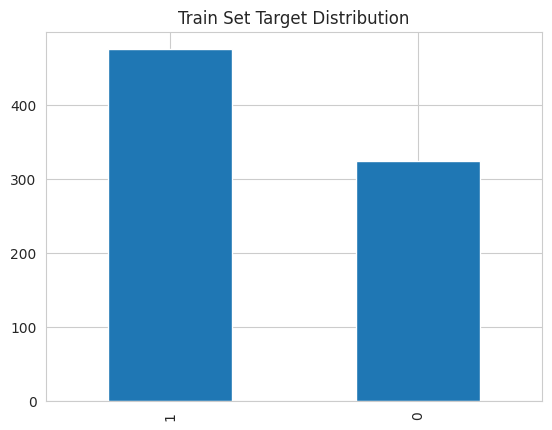

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [10]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(800, 5) (800,) (200, 5) (200,)


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
